In [1]:
import sympy
sympy.init_printing()
%matplotlib inline

Direct synthesis PID design
===========================

The direct synthesis design technique has a very appealing premise: we choose the desired closed loop behaviour and then rewrite the closed loop transfer function to find the controller which will give us this behaviour.

<img src="../../assets/standard_feedback.png" width=500em>

Specifically, we will specify what we want $\frac{Y}{Y_{SP}}$ to be, given that $D=0$. We will also then calculate $\frac{Y}{Y_{SP}}$ from the block diagram and then solve for $G_C$.

In [2]:
s, G_C = sympy.symbols('s, G_C')
tau_c, phi = sympy.symbols('tau_c, phi', positive=True, nonzero=True)

Let's start by choosing a first order plus dead time response for our system. If any of $G_v$ or $G_p$ contain dead time, we cannot avoid that dead time in the response of our system to a setpoint change. Becausre sympy wants to typeset exponents with positive values, I will be using a transformation $\phi = -\theta$ in this notebook to get forms similar to the textbook.

In [3]:
desired_Y_over_Y_sp = sympy.exp(phi*s)/(tau_c*s + 1)

This is what the prototypical response we've specified looks like. You can see that $\tau_c$ specifies the desired speed of the response. Also notice that the gain is 1, so that the process eventually follows the set point.

In [4]:
from ipywidgets import interact

In [5]:
t = sympy.Symbol('t', positive=True)
def plotresponse(theta=(0, 3.), tau_c_in=(1., 5.)):
    desired_response = sympy.inverse_laplace_transform(desired_Y_over_Y_sp.subs({phi: -theta, tau_c: tau_c_in})/s, s, t)
    p = sympy.plot(desired_response, (t, 0, 10), show=False)
    p2 = sympy.plot(1, (t, 0, 10), show=False)
    p.append(p2[0])
    p.show()
interact(plotresponse);

interactive(children=(FloatSlider(value=1.5, description='theta', max=3.0), FloatSlider(value=3.0, description='tau_c_in', max=5.0, min=1.0), Output()), _dom_classes=('widget-interact',))

Now, we calculate the closed loop transfer function. We will assume we have a model of the system called $\widetilde{G}$

In [6]:
Gtilde = sympy.Symbol(r'\widetilde{G}')
actual_Y_over_Y_sp = Gtilde*G_C/(1 + Gtilde*G_C)

To find the controller expression which will achieve our desired response, we simply solve for desired = actual

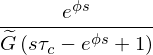

In [7]:
G_C_solved, = sympy.solve(desired_Y_over_Y_sp - actual_Y_over_Y_sp, G_C)
G_C_solved

We will approximate the dead time in the denominator by a first order Taylor expansion. Note that this choice is not completely unique. In general, we will choose the approximation (Padé or Taylor) which results the correct order of transfer function in the next steps.

In [8]:
denom = sympy.denom(G_C_solved)
G_C_rational = G_C_solved*denom/denom.subs(sympy.exp(phi*s), 1 + phi*s)

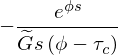

In [9]:
G_C_rational.simplify()

Now we can relate this to PID parameters for a general process. Here we have a PID controller expression.

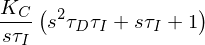

In [10]:
K_C, tau_I, tau_D = sympy.symbols('K_C, tau_I, tau_D', positive=True, nonzero=True)
PID = K_C*(1 + 1/(tau_I*s) + tau_D*s)
PID.expand().together()

And here we have a second order process with dead time.

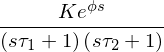

In [11]:
K, tau_c, tau_1, tau_2, phi, theta = sympy.symbols('K, tau_c, tau_1, tau_2, phi, theta', positive=True)
G = K*sympy.exp(phi*s)/((tau_1*s + 1)*(tau_2*s + 1))
G

Our goal is to find the PID parameters which match the rational $G_C$ we derived earlier.

In [12]:
target_G_C = G_C_rational.subs(Gtilde, G).expand().together()

We will create an object to hold on to equality in residual form ($G_c = G_{PID} \iff G_c - G_{PID} = 0$

In [13]:
zeroeq = (target_G_C - PID).simplify()

In [14]:
numer, denom = zeroeq.as_numer_denom()
eq = sympy.poly(numer, s)

The following straightforward solution of the equations yields the correct result. This does not currently work for Python 3.6 (see [this issue](https://github.com/sympy/sympy/issues/14607)). If this process fails for you, read on below.

In [15]:
eqs = eq.coeffs()

In [16]:
eqs

In [17]:
sympy.solve(eqs, [K_C, tau_D, tau_I])

KeyError: tau_D

## Alternate solution
If the simple solution above didn't work, we can do it a little more manually. Look at those equations again

In [18]:
eqs

With a little bit of help from us to choose the correct order to solve, we can get the solution in the book.

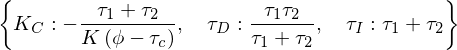

In [19]:
solution = {}
solution[K_C] = sympy.solve(eqs[1], K_C)[0]
solution[tau_D] = sympy.solve(eqs[0], tau_D)[0].subs(solution)
solution[tau_I] = sympy.solve(eqs[2], tau_I)[0].subs(solution).simplify()
solution